<a href="https://colab.research.google.com/github/ckj18/ToBigs_workspace/blob/main/tobigs19_KNN_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 19기 KNN 정규세션 과제

## KNN 구현해보기
### 1. Preprocssing / EDA
지금까지 배운 내용을 토대로 해당 데이터에 대해 자유롭게 전처리와 EDA를 진행해주세요.
### 2. KNN 구현 & 파라미터 튜닝
수업 내용 및 실습 자료를 참고하여 KNN을 구현하고 파라미터 튜닝을 하며 결과를 비교해주세요.
### 3. Evaluation
결과에 대한 평가를 진행하고, 나름의 해석을 달아주세요.

**데이터:** [blackfriday | Kaggle](https://www.kaggle.com/llopesolivei/blackfriday)

---

## 0. 데이터 불러오기

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings(action='ignore') 

df = pd.read_csv("blackfriday.csv", index_col = 0)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1001088,P00046042,F,0-17,10,A,3,0,5,17.0,NaN,2010
1,1004493,P00347742,F,0-17,10,A,1,0,7,NaN,NaN,4483
2,1005302,P00048942,F,0-17,10,A,1,0,1,4.0,NaN,7696
3,1001348,P00145242,F,0-17,10,A,3,0,2,4.0,NaN,16429
4,1001348,P00106742,F,0-17,10,A,3,0,3,5.0,NaN,5780


In [ ]:
# 데이터 정보 확인
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4998 entries, 0 to 4997
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   User_ID                     4998 non-null   int64  
 1   Product_ID                  4998 non-null   object 
 2   Gender                      4998 non-null   object 
 3   Age                         4998 non-null   object 
 4   Occupation                  4998 non-null   int64  
 5   City_Category               4998 non-null   object 
 6   Stay_In_Current_City_Years  4998 non-null   object 
 7   Marital_Status              4998 non-null   int64  
 8   Product_Category_1          4998 non-null   int64  
 9   Product_Category_2          3465 non-null   float64
 10  Product_Category_3          1544 non-null   float64
 11  Purchase                    4998 non-null   int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 507.6+ KB


## 1. 결측치 처리 

In [ ]:
# 결측치 비율 확인
print(df.isnull().sum() / len(df))

# 데이터의 절반 이상이 존재하지 않는 Product_Category_3를 제외
df = df.drop('Product_Category_3', axis=1)

User_ID                       0.000000
Product_ID                    0.000000
Gender                        0.000000
Age                           0.000000
Occupation                    0.000000
City_Category                 0.000000
Stay_In_Current_City_Years    0.000000
Marital_Status                0.000000
Product_Category_1            0.000000
Product_Category_2            0.306723
Product_Category_3            0.691076
Purchase                      0.000000
dtype: float64


In [ ]:
# 변수들 간 상관관계 파악
corr = df.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Purchase
User_ID,1.000000,-0.025709,0.029752,-0.007761,-0.003479,0.019966
Occupation,-0.025709,1.000000,0.018416,-0.015422,0.018819,0.034433
Marital_Status,0.029752,0.018416,1.000000,0.017766,0.042022,0.003284
Product_Category_1,-0.007761,-0.015422,0.017766,1.000000,0.474598,-0.374253
Product_Category_2,-0.003479,0.018819,0.042022,0.474598,1.000000,-0.177795
Purchase,0.019966,0.034433,0.003284,-0.374253,-0.177795,1.000000


count    4998.000000
mean        9.770708
std         5.104222
min         2.000000
25%         5.000000
50%         9.000000
75%        15.000000
max        18.000000
Name: Product_Category_2, dtype: float64


<AxesSubplot:xlabel='Product_Category_2', ylabel='Density'>

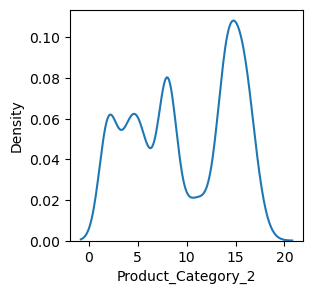

In [ ]:
# 데이터 분포와 분산 보존을 위해 결측치 대체
df['Product_Category_2_copy'] = df['Product_Category_2']

#df.sample()로 기존 데이터 분포에 맞춰 random 값 부여
temp = (df['Product_Category_2_copy'].dropna().sample(df['Product_Category_2_copy'].isnull().sum()))
temp.index = df[lambda x: x['Product_Category_2_copy'].isnull()].index # index 부여

# null인 index에 대체값 지정
df.loc[df['Product_Category_2_copy'].isnull(), 'Product_Category_2'] = temp

# df에서 copy 삭제
df = df.drop('Product_Category_2_copy', axis=1)

# Product_Category_2의 value 분포 파악
print(df['Product_Category_2'].describe())

plt.figure(figsize=(3,3))
sns.kdeplot(x='Product_Category_2', data=df)

## 2. EDA

Unique value of Product_ID 1797
Unique value of Gender 2
Unique value of Age 7
Unique value of City_Category 3
Unique value of Stay_In_Current_City_Years 5


<AxesSubplot:xlabel='Stay_In_Current_City_Years', ylabel='count'>

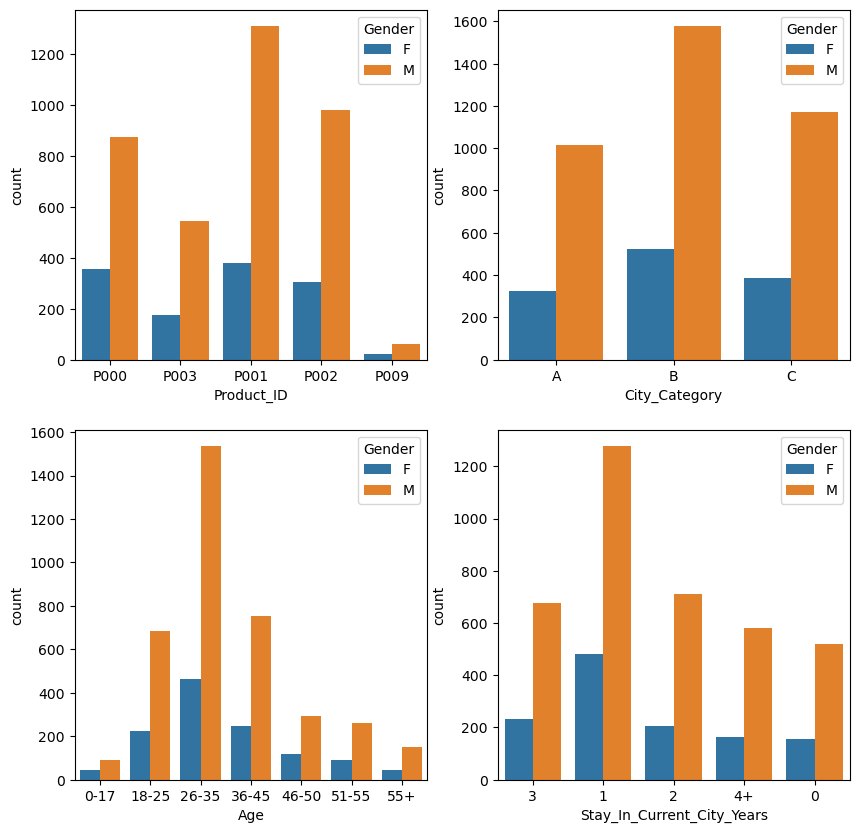

In [ ]:
# 범주형 데이터 분석
cate_col =  [column for column in df.columns if df[column].dtypes == 'object']

# 각 column별로 unique 개수 확인
for col in cate_col:
    print("Unique value of", col, len(df[col].unique()))

# unique 개수가 많은 Product_ID value 축소
df['Product_ID'] = df['Product_ID'].map(lambda x:x[:4])

# 데이터 시각화(target 변수 City_Category에 대한 분포)
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,10))

sns.countplot(x=cate_col[0], data=df, ax=ax[0,0], hue='Gender')
sns.countplot(x=cate_col[2], data=df, ax=ax[1,0], hue='Gender')
sns.countplot(x=cate_col[3], data=df, ax=ax[0,1], hue='Gender')
sns.countplot(x=cate_col[4], data=df, ax=ax[1,1], hue='Gender')

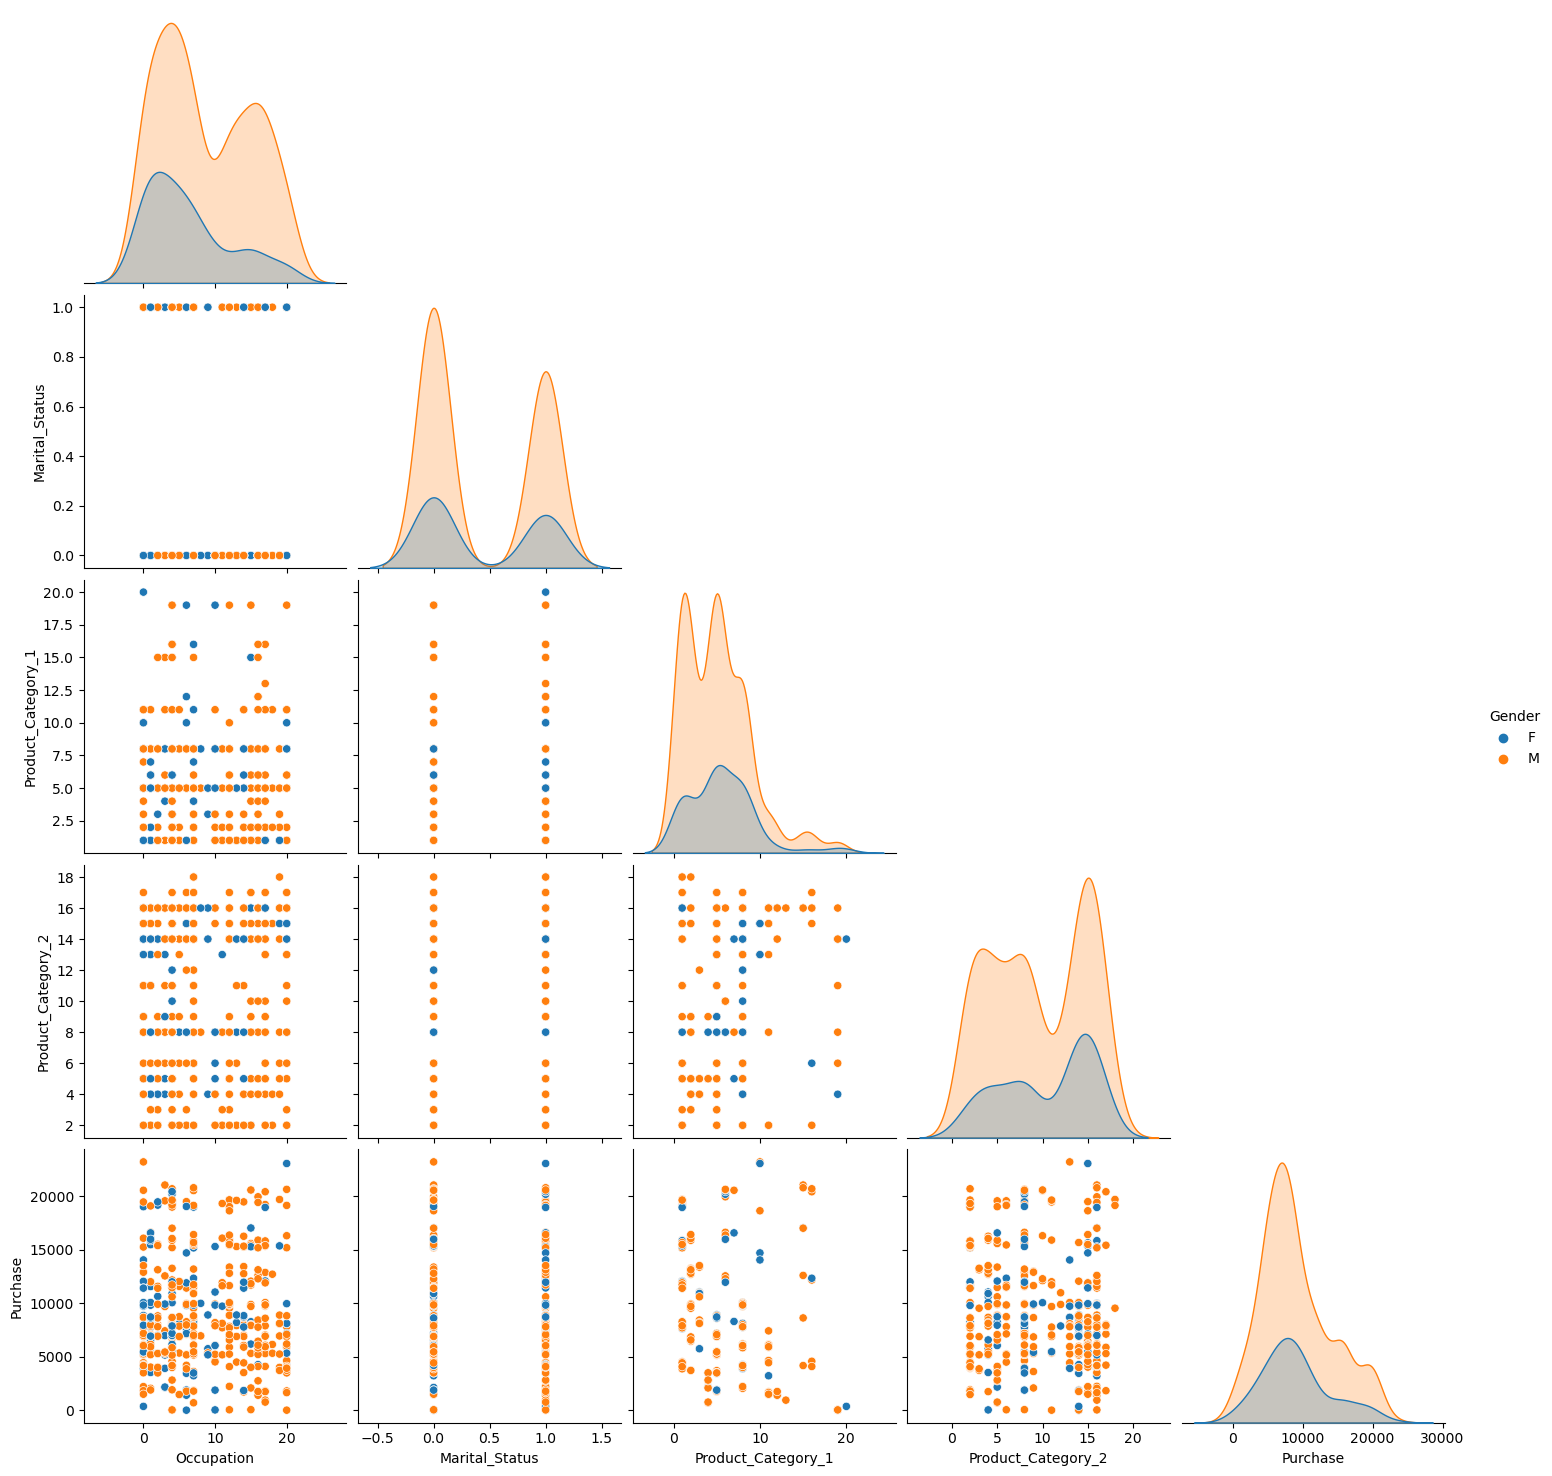

In [ ]:
# 수치형 데이터 분석
num_col =  [column for column in df.columns if df[column].dtypes != 'object']

# USER_ID를 제외한 column에 대한 데이터
num_col_gen = num_col[1:]
num_col_gen.append('Gender')

# 임의의 데이터 500개를 추출하여 Gender에 따른 시각화
df_sample = df[num_col_City].sample(500)
sns.pairplot(data=df_sample, hue='Gender', height=3, corner=True)

## 3. Model 

In [ ]:
# 인코딩을 하기 위해 LabelEncoder 사용
le = LabelEncoder()

# fit_fransform을 통해 데이터를 인코딩
for col in cate_col:
    df[col] = le.fit_transform(df[col])
    df[col] = df[col].astype(int)

In [ ]:
X = df.drop(['Gender'], axis=1)
y = df['Gender']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# train, test split의 사이즈
print("X_train's shape : ", X_train.shape)
print("X_test's shape : ", X_test.shape)
print("y_train's shape : ", y_train.shape)
print("y_test's shape : ", y_test.shape)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_train's shape :  (3998, 10)
X_test's shape :  (1000, 10)
y_train's shape :  (3998,)
y_test's shape :  (1000,)


Best score: 0.7606289111389236
Best k: 29


Text(0, 0.5, 'CV Accuracy')

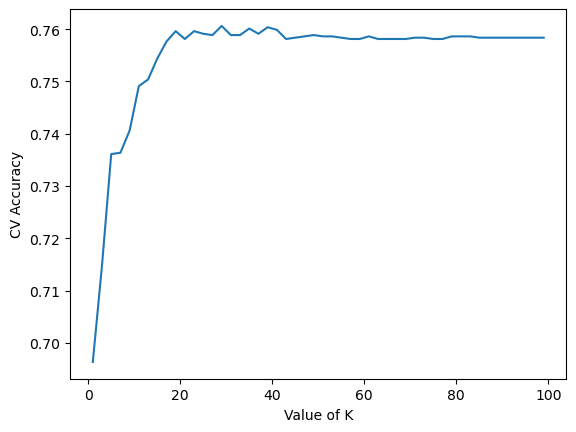

In [ ]:
# X_train의 평균, 분산 계산
mean = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)

# X_train을 정규화하여 train_scaled에 저장
train_scaled = (X_train - mean) / std
test_scaled = (X_test - mean) / std

# K의 범위를 1~100의 홀수로 지정
k_range = [k for k in range(1,100) if k % 2 != 0]        
k_score = []                      

# 유클리디안 거리와 교차 검증을 사용
for k in k_range :
    knn = KNeighborsClassifier(k, metric='euclidean')
    scores = cross_val_score(knn, train_scaled, y_train, cv=5, scoring = "accuracy")   
    k_score.append(scores.mean())                   

# Best score와 K를 계산    
print("Best score:", max(k_score))
print("Best k:", k_range[k_score.index(max(k_score))])
plt.plot(k_range, k_score)
plt.xlabel('Value of K')
plt.ylabel('CV Accuracy')

## 4. Evaluation

In [ ]:
from sklearn import metrics

knn = KNeighborsClassifier(29, metric='euclidean')
knn.fit(train_scaled, y_train)

# 0을 잘 예측하지 못함
results = knn.predict(test_scaled)
print(metrics.classification_report(y_test,results, digits=2))


              precision    recall  f1-score   support

           0       0.65      0.04      0.08       267
           1       0.74      0.99      0.85       733

    accuracy                           0.74      1000
   macro avg       0.69      0.52      0.46      1000
weighted avg       0.71      0.74      0.64      1000

